In [1]:
import time

import jax
import jax.numpy as jnp
from jax import lax, jit
from evosax import CMA_ES, SimAnneal

from envs.photon_env import BatchedPhotonLangevinReadoutEnv

In [2]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [3]:
env = BatchedPhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    batchsize=batchsize,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [4]:
# Initialise Seeding

seed = 0
rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [5]:
# Instantiate the Different Search Strategies

cma_strategy = CMA_ES(popsize=batchsize, num_dims=env.num_actions, elite_ratio=0.6)
cma_params = cma_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)

sim_anneal = SimAnneal(popsize=batchsize, num_dims=env.num_actions)
sim_params = sim_anneal.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [6]:
# Defining Custom Rollout

def custom_rollout(batch_actions):
    res_drive = env.a0 * batch_actions.astype(jnp.float64)
    normalizing_factor = jnp.clip(
        env.mu * env.a0 / jnp.absolute(res_drive),
        0.0,
        1.0,
    )
    res_drive *= normalizing_factor
    res_drive = env.batched_smoother(res_drive)

    batch_res = env.batched_results(res_drive)
    reward, _ = env.batched_reward_and_state(
        batch_res.astype(env.float_dtype), res_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32)

In [25]:
# Training Stuff

strat = sim_anneal
params = sim_params

init_state = strat.initialize(rng, params)

def generation_func(rng, state):
    rng, rng_gen = jax.random.split(rng, 2)
    x, state = strat.ask(rng_gen, state, params)
    fitness = custom_rollout(x)
    state = strat.tell(x, fitness, state, params)
    return (rng, state)

jitted_gen_func = jit(generation_func)

# Defining Update Func
def update_func(carry, _):
    _rng, state = carry
    _rng, state = jitted_gen_func(_rng, state)
    # jax.debug.print("best fitness: {best}", best=state.best_fitness)
    return (_rng, state), state.best_fitness

# Define your loop
def run_loop(rng, state, num_iterations):
    init_value = (rng, state)
    final_value, fitness_list = lax.scan(update_func, init_value, jnp.zeros(num_iterations))
    _, final_state = final_value
    return fitness_list, final_state

# Run the loop
print("Starting Run")
start = time.time()
fitness_list, final_state = run_loop(_rng, init_state, int(2e4))
print(f"Time Taken for 1000 updates: {time.time() - start}")

Starting Run
Time Taken for 1000 updates: 295.977498292923


-22.976873


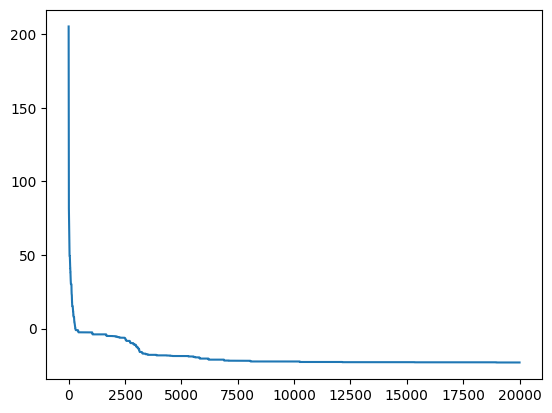

In [26]:
import matplotlib.pyplot as plt
print(jnp.min(fitness_list))
plt.plot(fitness_list)
plt.show()

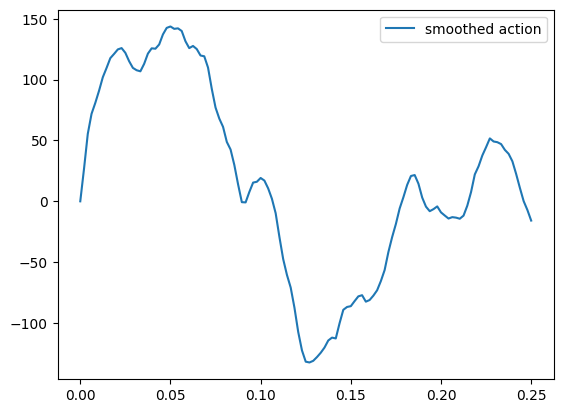

In [36]:
action = final_state.best_member
action *= env.a0
action = env.drive_smoother(action)

# plt.plot(env.ts_action, action, label='action')
plt.plot(env.ts_action, action, label='smoothed action')
plt.legend()
plt.show()

In [37]:
batched_action = jnp.tile(action, (batchsize, 1))

batched_res = env.batched_results(batched_action)
(
    max_pf,
    max_photons,
    photon_reset_time,
    pulse_end_times,
    max_pf_times,
    smoothness_vals,
    b_pf,
    b_higher_photons,
    _
) = env.batched_extract_values(batched_res, batched_action)

reward, _ = env.batched_reward_and_state(
    batched_res,
    batched_action
)

print(max_pf_times[0])
print(photon_reset_time[0])
print(pulse_end_times[0])
print(reward[0])
print(max_pf[0])

0.11597222222222223
0.2465277777777778
0.2465277777777778
22.976821013242148
2.54735568948295


0.010135224799764656
350
0.010135224799764656
350


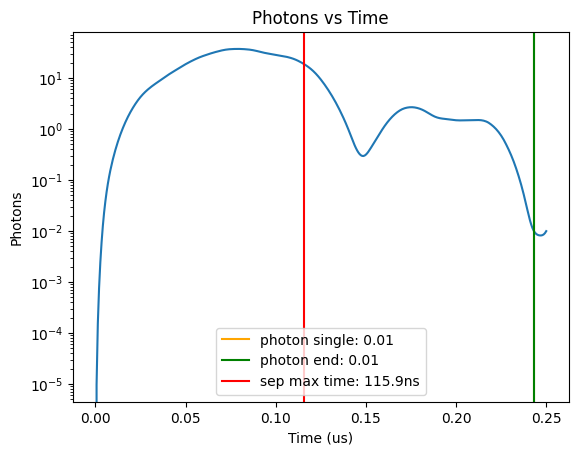

In [38]:
single_photon = b_higher_photons[0]

single_res = batched_res[0]
g_real, g_imag, e_real, e_imag = single_res.T
single_sep = jnp.sqrt((g_real - g_imag) ** 2 + (e_real - e_imag) ** 2)
single_sep = b_pf[0]

single_photon = g_real ** 2 + g_imag ** 2

ext = 50
ext_15 = -1
ext_2 = -1

s_photon = jnp.abs(single_photon - nR)

argmin = jnp.argmin(s_photon[ext:ext_2]) + ext
min_photon = single_photon[argmin]

argmin_2 = jnp.argmin(s_photon[ext:ext_15]) + ext
min_photon_2 = single_photon[argmin_2]

argmax = jnp.argmax(single_sep)

print(min_photon)
print(argmin)

print(min_photon_2)
print(argmin_2)

plt.plot(env.ts_sim, single_photon)
plt.axvline(x=env.ts_sim[argmin_2], label=f'photon single: {int(1e3*min_photon_2)/1e3}', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'photon end: {int(1e3*min_photon)/1e3}', color='green')
plt.axvline(x=env.ts_sim[argmax], label=f'sep max time: {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.xlabel('Time (us)')
plt.ylabel('Photons')
plt.title('Photons vs Time')
plt.yscale('log')
plt.legend()
plt.show()

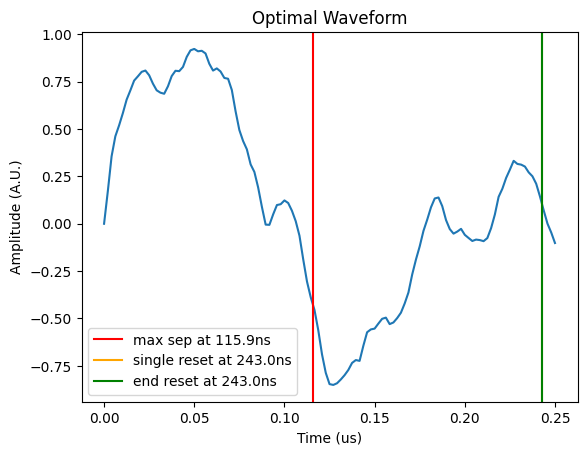

In [40]:
plt.plot(env.ts_action, action / env.mu / env.a0)
plt.axvline(x=env.ts_sim[argmax], label=f'max sep at {int(1e4*env.ts_sim[argmax])/1e1}ns', color='red')
plt.axvline(x=env.ts_sim[argmin_2], label=f'single reset at {int(1e4*env.ts_sim[argmin_2])/1e1}ns', color='orange')
plt.axvline(x=env.ts_sim[argmin], label=f'end reset at {int(1e4*env.ts_sim[argmin])/1e1}ns', color='green')
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Optimal Waveform')
plt.legend()
plt.show()